In [2]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
import joblib
import sasc.config
import numpy as np
import re
from collections import defaultdict
from copy import deepcopy
import pandas as pd
import adjustText
# import story_helper

def get_word_chunks(t):
    # split words based on timing into bins of 2 seconds
    word_chunks = []
    current_time = 0
    for i in range(len(t)):
        if i == 0:
            word_chunks.append([t['word'][i]])
        elif t['time_running'][i] - current_time < 2:
            word_chunks[-1].append(t['word'][i])
        else:
            word_chunks.append([t['word'][i]])
            current_time += 2
    return word_chunks

pilot_data_dir = join(sasc.config.FMRI_DIR, 'story_data/20230504')
resp_np_files = os.listdir(pilot_data_dir)
resps_dict = {k: np.load(join(pilot_data_dir, k)) for k in tqdm(resp_np_files)}
story_data = joblib.load(join(sasc.config.RESULTS_DIR, 'pilot_story_data.pkl'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 6/6 [00:38<00:00,  6.45s/it]


In [3]:
def plot_annotated_resp(
    voxel_num: int,
    word_chunks,
    voxel_resp,
    expl_voxel,
    start_times,
    end_times,
    story_data,
):
    plt.figure(figsize=(22, 6))
    plt.plot(voxel_resp)

    # annotate top 5 voxel_resps with word_chunks
    texts = []
    top_5_resp_positions = np.argsort(voxel_resp)[::-1][:5]
    for i, resp_position in enumerate(top_5_resp_positions):
        plt.plot(resp_position, voxel_resp[resp_position], "o", color="black")
        text = (
            " ".join(word_chunks[resp_position - 1])
            + "\n"
            + " ".join(word_chunks[resp_position])
        )
        texts.append(
            plt.annotate(
                text, (resp_position,
                       voxel_resp[resp_position]), fontsize="x-small"
            )
        )

    # annotate bottom 5 voxel_resps with word_chunks
    bottom_5_resp_positions = np.argsort(voxel_resp)[:5]
    for i, resp_position in enumerate(bottom_5_resp_positions):
        plt.plot(resp_position, voxel_resp[resp_position], "o", color="black")
        text = (
            " ".join(word_chunks[resp_position - 2])
            + "\n"
            + " ".join(word_chunks[resp_position - 1])
            + "\n"
            + " ".join(word_chunks[resp_position])
        )
        texts.append(
            plt.annotate(
                text, (resp_position,
                       voxel_resp[resp_position]), fontsize="x-small"
            )
        )

    # clean up plot
    adjustText.adjust_text(texts, arrowprops=dict(
        arrowstyle="->", color="gray"))
    plt.grid(alpha=0.4, axis="y")
    xticks = np.array([start_times, end_times]).mean(axis=0)
    plt.xticks(xticks, expls, rotation=45, fontsize="x-small")

    for i, (start_time, end_time) in enumerate(zip(start_times, end_times)):
        if i == voxel_num:
            plt.axvspan(start_time, end_time, facecolor="green", alpha=0.1)
        elif i % 2 == 0:
            plt.axvspan(start_time, end_time, facecolor="gray", alpha=0.1)
        else:
            plt.axvspan(start_time, end_time, facecolor="gray", alpha=0.0)

    # plot ngram examples
    word_chunk_deltas = defaultdict(list)
    i_start_voxel = start_times[voxel_num]
    i_end_voxel = end_times[voxel_num] + 1
    if i_end_voxel > len(voxel_resp):
        i_end_voxel = len(voxel_resp)
    idxs = np.arange(i_start_voxel, i_end_voxel)
    plt.plot(idxs, voxel_resp[idxs], color="C0", linewidth=2)
    idxs_wc = np.where(word_chunks_contain_example_ngrams[idxs])[0]
    plt.plot(idxs[idxs_wc], voxel_resp[idxs[idxs_wc]],
             "^", color="C1", linewidth=2)
    for delta_num in [1, 2, 3, 4, 5]:
        for idx in idxs_wc:
            if idx + delta_num < len(idxs):
                word_chunk_deltas[delta_num].append(
                    voxel_resp[idxs][idx + delta_num] - voxel_resp[idxs][idx]
                )

    plt.ylabel(
        f'"{expl_voxel}" voxel response\n({story_data["story_name_new"][story_num][3:-10]})'
    )
    # plt.show()
    return word_chunk_deltas


word_chunk_deltas = []

for story_num in range(6):
    paragraphs = story_data["story_text"][story_num].split("\n\n")
    prompts = story_data["prompts"]
    t = story_data["timing"][story_num]

    rows = story_data["rows"][story_num]
    voxel_nums = rows["voxel_num"]
    expls = rows["expl"]

    r_curves = resps_dict[story_data["story_name_new"]
                          [story_num]].T[voxel_nums]
    word_chunks = get_word_chunks(t)
    start_times, end_times = story_helper.get_start_end_times(t, paragraphs)

    # example_ngrams and word_chunks
    ps = prompts[story_num]
    example_ngrams_list = sum(
        [story_helper.find_all_examples_within_quotes(x) for x in ps], []
    )
    word_chunks_contain_example_ngrams = np.zeros(len(word_chunks))
    for i, wc in enumerate(word_chunks):
        for ngram in example_ngrams_list:
            if any([ngram in w for w in wc]):
                word_chunks_contain_example_ngrams[i] = 1
                break

    for voxel_num in tqdm(range(17)):
        expl_voxel = expls[voxel_num]
        voxel_resp = r_curves[voxel_num]
        word_chunk_deltas.append(
            plot_annotated_resp(
                voxel_num,
                word_chunks,
                voxel_resp,
                expl_voxel,
                start_times,
                end_times,
                story_data,
            )
        )
    story_helper.save_figs_to_single_pdf(
        filename=f'../results/pilot_plots/{story_data["story_name_new"][story_num][3:-10]}_curves.pdf'
    )
    plt.close("all")

KeyError: 'GenStory1_resps.npy'

### Plot ngram delta

Delta 1 mean: 0.11071012359711764 +/- 0.05939263678326731
Delta 2 mean: 0.14893023685322224 +/- 0.06965380142554627
Delta 3 mean: 0.17944611350699183 +/- 0.07474460991407371
Delta 4 mean: 0.13149339521186112 +/- 0.08277549567660428
Delta 5 mean: 0.05282201751903965 +/- 0.08359894411895956


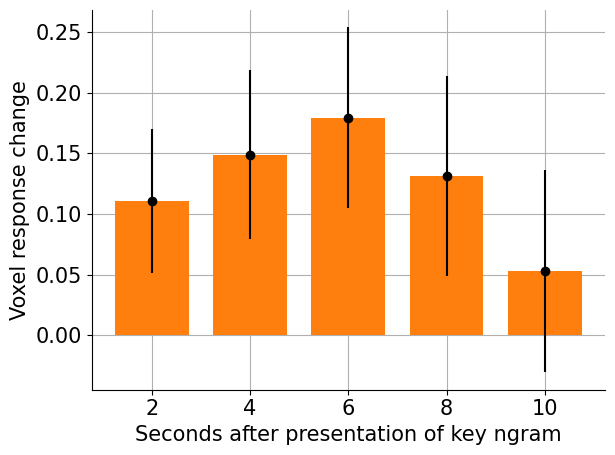

In [11]:
means = []
sems = []
delta_offsets = [1, 2, 3, 4, 5]
for i in delta_offsets:
    deltas = sum([x[i] for x in word_chunk_deltas], [])
    # plt.hist(deltas, label='Delta ' + str(i), alpha=0.5)
    # plt.axvline(np.mean(deltas), linewidth=1, color=f'C{i - 1}')

    means.append(np.mean(deltas))
    sems.append(np.std(deltas) / np.sqrt(len(deltas)))
    print(f'Delta {i} mean: {means[-1]} +/- {sems[-1]}')
# plt.legend()

# barplot of means
delta_offsets = 2 * np.array(delta_offsets)
plt.grid(zorder=-100)
plt.bar(delta_offsets, means, color='C1', zorder=100, width=1.5)
plt.errorbar(delta_offsets, means, yerr=sems,
             fmt='o', color='black', zorder=101)
plt.xticks(delta_offsets)
plt.xlabel('Seconds after presentation of key ngram')
plt.ylabel('Voxel response change')
plt.show()